                                                FACE RECOGNITION PROJECT (Resnet50 + SVM)

Quoc Dat Cao  301550055

Import useful library
os:  
    Used for interacting with the operating system.
    Common operations include creating directories, navigating file paths, and managing files.
random:
    Provides functions to introduce randomness, such as shuffling lists or selecting random samples.

shutil:
    Used for high-level file operations, such as copying and moving files between directories.

pandas (pd):
    A powerful library for data manipulation and analysis.
    Used to read, group, and process structured data (e.g., CSV files).

numpy (np):
    A fundamental library for numerical computing in Python.
    Used to handle arrays and perform mathematical operations efficiently.

joblib:
    Used for saving and loading Python objects, such as machine learning models, to/from disk.

seaborn (sns):
    A data visualization library built on top of Matplotlib.
    Used to create visually appealing charts, such as heatmaps for confusion matrices.

matplotlib.pyplot (plt):
    The foundational plotting library in Python.
    Used to visualize data through graphs and charts.


--------------------------------Deep Learning Library--------------------------------

tensorflow.keras.applications.ResNet50:
    Provides access to the ResNet-50 model, pre-trained on ImageNet.
    Used for extracting features from images.

tensorflow.keras.models.Model:
    Used to define and manipulate Keras models.
    Useful for creating custom models by specifying inputs and outputs.

tensorflow.keras.applications.resnet50.preprocess_input:
    Prepares image data to match the input requirements of the ResNet-50 model 
    (e.g., scaling pixel values).

tensorflow.keras.preprocessing.image:
    Contains utilities for image processing, such as loading images and converting them to arrays.

tensorflow.keras.layers.GlobalAveragePooling2D:
    A Keras layer used to reduce the dimensionality of the ResNet feature maps 
    by computing the average of each feature map.

sklearn.svm.SVC:
    Implements a Support Vector Classifier, which is used for training a classification model.

sklearn.preprocessing.StandardScaler:
    Used to scale features by removing the mean and scaling to unit variance.
    Ensures that all features contribute equally to the SVM.

sklearn.pipeline.make_pipeline:
    Creates a pipeline to streamline the combination of preprocessing steps 
    (e.g., scaling) and the SVM model.

sklearn.metrics:
    Provides tools to evaluate model performance.
    Includes metrics like accuracy, classification reports, and confusion matrices.




In [1]:
import os
import random
import shutil
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


2024-12-02 20:15:37.782065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 20:15:37.832203: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


First step is Data Preparation.
    In this step, the number of image of each label(name of the person)'s data is separated into 80% for training and 20% for testing.
    I also count the number of pictures a person has in the data to have an overall look of the dataset. The dataset was found on Kaggle from this link: https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset

    Person with the largest number of images: Brad Pitt (120 images)
    Person with the smallest number of images: Kashyap (30 images)
    

In [2]:
#DATA PREPARATION
# File paths
data_folder = "data"
train_folder = "train"
test_folder = "test"
csv_file_path = 'dataset.csv'

# Create train and test directories
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Read the dataset
dataset = pd.read_csv(csv_file_path)

# Group images by label (person name)
grouped = dataset.groupby("label")

# Dictionary to store the count of images for each person
image_counts = {}

for label, group in grouped:
    # Get all image filenames for this person
    images = group["id"].tolist()
    
    # Count the number of images for this label
    image_counts[label] = len(images)
    
    # Shuffle the images for randomness
    random.shuffle(images)
    
    # Split images: 80% to train, remaining to test
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]
    
    # Create label-specific folders in train and test
    train_person_folder = os.path.join(train_folder, label)
    test_person_folder = os.path.join(test_folder, label)
    os.makedirs(train_person_folder, exist_ok=True)
    os.makedirs(test_person_folder, exist_ok=True)
    
    # Move 80% images to train folder
    for img in train_images:
        src = os.path.join(data_folder, img)
        dst = os.path.join(train_person_folder, img)
        if os.path.exists(src):
            shutil.copy(src, dst)
    
    # Move the remaining 20% to the test folder
    for img in test_images:
        src = os.path.join(data_folder, img)
        dst = os.path.join(test_person_folder, img)
        if os.path.exists(src):
            shutil.copy(src, dst)

# Find the person with the largest and smallest number of images
largest_person = max(image_counts, key=image_counts.get)
smallest_person = min(image_counts, key=image_counts.get)

# Display the results
print("\nImage Counts for Each Person:")
for label, count in image_counts.items():
    print(f"{label}: {count}")

print(f"\nPerson with the largest number of images: {largest_person} ({image_counts[largest_person]} images)")
print(f"Person with the smallest number of images: {smallest_person} ({image_counts[smallest_person]} images)")

print("\nData preparation complete!")


Image Counts for Each Person:
Akshay Kumar: 50
Alexandra Daddario: 92
Alia Bhatt: 79
Amitabh Bachchan: 74
Andy Samberg: 92
Anushka Sharma: 68
Billie Eilish: 98
Brad Pitt: 120
Camila Cabello: 87
Charlize Theron: 78
Claire Holt: 96
Courtney Cox: 80
Dwayne Johnson: 61
Elizabeth Olsen: 71
Ellen Degeneres: 75
Henry Cavill: 106
Hrithik Roshan: 101
Hugh Jackman: 112
Jessica Alba: 108
Kashyap: 30
Lisa Kudrow: 70
Margot Robbie: 72
Marmik: 32
Natalie Portman: 105
Priyanka Chopra: 102
Robert Downey Jr: 113
Roger Federer: 77
Tom Cruise: 58
Vijay Deverakonda: 115
Virat Kohli: 49
Zac Efron: 91

Person with the largest number of images: Brad Pitt (120 images)
Person with the smallest number of images: Kashyap (30 images)

Data preparation complete!


---------------------------------------------------FEATURE EXTRACTION-------------------------------------------------

Firstly, load the model Resnet50

In [3]:
imagesize_target=224
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(imagesize_target, imagesize_target, 3))

2024-12-02 20:15:40.042809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-02 20:15:40.042831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: scott-ThinkPad-P15
2024-12-02 20:15:40.042834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: scott-ThinkPad-P15
2024-12-02 20:15:40.043031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 550.120.0
2024-12-02 20:15:40.043044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 550.120.0
2024-12-02 20:15:40.043046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 550.120.0
2024-12-02 20:15:40.043895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI 

    The original resnet model used 224x224 image size, during experiment with different size, which I give more detail in the report, I see that this image's size get better result although it cause slower in performance than smaller size. The original images in dataset have size 160x160. However, this size yield lower accuracy.

    Let look at the model Resnet50!
    ResNet50 is a deep convolutional neural network with 50 layers designed to handle image classification and feature extraction tasks.
    It's a powerful architecture for transfer learning because it is pre-trained on the large ImageNet dataset and captures generic image features.

    >> weights='imagenet' <<
    It loads pre-trained weights learned from the ImageNet dataset, which contains over 14 million labeled images.
    Transfer learning: Leverage pre-trained weights instead of training the network from scratch, saving time. These weights are optimized for common image patterns like edges, shapes, and textures.

    >> include_top=False <<
    It means that I don't use the fully connected (dense) layers at the top of the network because I use svm classifier for the classification task, this I won't use this layers. Fully connected layers in the default ResNet50 are specific to the ImageNet classification task (1,000 classes). Excluding the top layers leaves only the convolutional base, which outputs feature maps that are general-purpose. This allows me to use ResNet50 for tasks like feature extraction or fine-tuning with my own classifier.

    >> input_shape=(imagesize_target, imagesize_target, 3) <<
    It specifies the shape of the input images, where I play with my parameter, change the size by adjusting the imagesize_target to experiment how it will affect the accuracy.3: The number of color channels (RGB).
    Customizing imagesize_target:
        Smaller sizes (e.g., 128x128) are faster to process and require less memory but may lose spatial detail lead to lower accuracy.
        Larger sizes (e.g., 299x299) retain more detail but require more resource.
    


    The ImageDataGenerator object (test_datagen) preprocesses images to ensure they are compatible with the pre-trained ResNet50 model. Pixel values, which are originally in the range [0, 255], are normalized to a range suitable for ResNet50, specifically [-1, 1], and resize it to experiment imagesize_target.
    >> batch_size=32 << specifies that 32 images are processed at a time. It balances memory usage and computation speed.
    -> Smaller for limited memory.
    -> Larger for faster training with sufficient memory.

In [4]:
# Data generators for train and test sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(imagesize_target, imagesize_target),
    batch_size=32,  # You can adjust this based on your system's memory
    class_mode=None,  # No labels required for feature extraction
    shuffle=False  # Keep order consistent for mapping labels later
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(imagesize_target, imagesize_target),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 2037 images belonging to 31 classes.
Found 525 images belonging to 31 classes.


The code below to map the person name to label's number for final manual visual testing.

In [5]:
class_indices = train_generator.class_indices
inverse_class_indices = {v: k for k, v in class_indices.items()}  # Reverse the dictionary
joblib.dump(inverse_class_indices, "class_mapping.pkl")
print("Class mapping saved!")

Class mapping saved!


This code snippet is responsible for extracting features from images using a pre-trained ResNet50 model and saving them for later use. 

In [6]:
# Extract features for train set
print("Extracting features for training set...")
train_features = resnet_model.predict(train_generator, verbose=1)
train_labels = train_generator.classes  # Class indices corresponding to features
np.save("train_features.npy", train_features)  # Save features
np.save("train_labels.npy", train_labels)  # Save labels
print("Training features saved!")

Extracting features for training set...
64/64 [==============================] - 43s 663ms/step
Training features saved!


resnet_model.predict(train_generator):
    Uses the pre-trained ResNet50 model (resnet_model) to process the images from the train_generator.
    Each image is passed through the ResNet50 convolutional layers, which output high-dimensional feature maps for each image.

train_generator.classes:
    Retrieves the labels (class indices) for each image in the training set. 
    These are integer representations of the classes (e.g., 0, 1, 2, ...).

np.save("train_features.npy", train_features):
    Saves the extracted features to a .npy file for later use.
    These features can be loaded later without needing to re-extract them from ResNet50.

np.save("train_labels.npy", train_labels):
    Saves the corresponding labels for the training images to another .npy file.

Output:
    The extracted features and their corresponding labels are stored in the files:
        train_features.npy
        train_labels.npy

In [7]:
# Extract features for test set
print("Extracting features for testing set...")
test_features = resnet_model.predict(test_generator, verbose=1)
test_labels = test_generator.classes  # Class indices corresponding to features
np.save("test_features.npy", test_features)  # Save features
np.save("test_labels.npy", test_labels)  # Save labels
print("Testing features saved!")

Extracting features for testing set...
17/17 [==============================] - 11s 653ms/step
Testing features saved!


resnet_model.predict(test_generator): Processes the test images using the same ResNet50 model, extracting feature maps for each test image. These features are used for evaluating the model's performance later.

test_generator.classes: Retrieves the class indices (integer labels) for the test images.

Saving the Data: Features are saved to test_features.npy. Labels are saved to test_labels.npy.

Output: The extracted features and labels are stored in test_features.npy and test_labels.npy

Global Average Pooling (GAP) is a crucial step in the pipeline because it prepares the feature maps output by ResNet50 for use in my refered machine learning classifier SVM.

ResNet50: Output, Shape

When include_top=False, ResNet50 outputs a 4D tensor (feature maps) of shape:(num_samples, height, width, channels) Traditional classifiers like SVM require 2D input, where each sample is represented as a single fixed-length vector.So the 4D tensor from ResNet50 needs to be flattened into a 2D matrix:(num_samples, 2048).

GAP flattens the spatial dimensions (height and width) by computing the average of all pixel values in each channel.

The resulting output has one value per channel, which represents the channel's overall "activation" or importance.

This reduces the dimensionality of the feature map while retaining its semantic meaning.

If I don't use GAP and try to pass the 4D tensor ((7,7,2048)(7,7,2048)) to the SVM, it causes error in SVM


In [8]:
# Optionally, perform Global Average Pooling to flatten features
gap = GlobalAveragePooling2D()
train_features_flat = gap(train_features).numpy()  # Shape: (num_train_samples, 2048)
test_features_flat = gap(test_features).numpy()    # Shape: (num_test_samples, 2048)

# Save flattened features
np.save("train_features_flat.npy", train_features_flat)
np.save("test_features_flat.npy", test_features_flat)
print("Flattened features saved!")

Flattened features saved!


---------------------------------------------------SVM CLASSIFICATION-------------------------------------------------

Firstly, reload the saved train and test features 

make_pipeline(StandardScaler(), SVC(...)) creates a pipeline 

where:
StandardScaler(): Standardizes the feature data by removing the mean and scaling to unit variance. Ensures that all features contribute equally, as SVMs are sensitive to the scale of features.
SVC: Implements a Support Vector Classifier (SVM).

Parameters:
kernel='linear': Uses a linear decision boundary (hyperplane) to separate classes.
C=1: Controls the regularization strength (trade-off between complexity and misclassification).
degree=1: Has no effect here since the kernel is linear (only relevant for polynomial kernels).
probability=True: Enables probability estimates for predictions.

In [9]:
# Step 1: Load Saved Features and Labels
print("Loading features and labels...")
train_features = np.load("train_features_flat.npy")  # Flattened training features
test_features = np.load("test_features_flat.npy")    # Flattened testing features
train_labels = np.load("train_labels.npy")           # Training labels
test_labels = np.load("test_labels.npy")             # Testing labels
print("Features and labels loaded successfully!")

Loading features and labels...
Features and labels loaded successfully!


svm_classifier.fit(train_features, train_labels):
    Trains the SVM classifier using the training features (train_features) and their corresponding labels (train_labels).
    The model learns a linear hyperplane to separate the classes in the feature space.

In [10]:
# Step 2: Train the SVM Classifier
print("Training SVM classifier...")
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear', C=2, degree=1, probability=True))
svm_classifier.fit(train_features, train_labels)
print("SVM training complete!")

Training SVM classifier...
SVM training complete!


Step 3 and 4: calculate the accuracy of the svm model and save the model for later use

In [11]:
# Step 3: Evaluate the SVM Classifier
print("Evaluating the classifier...")
test_predictions = svm_classifier.predict(test_features)
# Calculate and display accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Evaluating the classifier...
Test Accuracy: 82.29%


Compares the predicted labels (test_predictions) from my SVM model with the true labels (test_labels) in the test set.
and have an overall Performance Evaluation:
    Accuracy is a quick way to evaluate how well my model performs on the test set.
    It shows model's correctness.

In [12]:
# Detailed classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Step 4: Save the Trained SVM Model
print("Saving the trained SVM model...")
joblib.dump(svm_classifier, "svm_classifier.pkl")
resnet_model.save("resnet_model.h5")
print("SVM model saved as 'svm_classifier.pkl'.")


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.79      0.79      0.79        19
           2       0.81      0.81      0.81        16
           3       1.00      1.00      1.00        15
           4       0.86      1.00      0.93        19
           5       0.67      0.29      0.40        14
           6       0.90      0.90      0.90        20
           7       0.71      0.83      0.77        24
           8       0.88      0.83      0.86        18
           9       0.67      0.62      0.65        16
          10       0.75      0.75      0.75        20
          11       0.81      0.81      0.81        16
          12       0.93      1.00      0.96        13
          13       0.72      0.87      0.79        15
          14       0.82      0.93      0.88        15
          15       0.89      0.77      0.83        22
          16       0.79      0.71      0.75        21
    

----------------------------------------------------------TESTING-------------------------------------------------

Step 1 and 2: reload saved features and label and reuse the trained SVM model

In [13]:
# Step 1: Load Test Features and Labels
print("Loading test features and labels...")
test_features = np.load("test_features_flat.npy")  # Flattened test features
test_labels = np.load("test_labels.npy")          # Corresponding labels
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Step 2: Load the Trained SVM Model
print("Loading the trained SVM model...")
svm_classifier = joblib.load("svm_classifier.pkl")
print("SVM model loaded successfully!")

Loading test features and labels...
Test features shape: (525, 2048)
Test labels shape: (525,)
Loading the trained SVM model...
SVM model loaded successfully!


In Step 3

predict() Method:

Takes the feature vectors from the test set as input (test_features).
For each test sample, it uses the trained SVM model to determine which class the sample belongs to

by:
Computing the distance of the sample from the hyperplane (decision boundary). Assigning a class based on which side of the hyperplane the sample falls.

Output:
Returns an array (test_predictions) containing the predicted class labels for all test samples.

In Step 4:

Accuracy measures the overall correctness of the model's predictions on the test set. accuracy_score(test_labels, test_predictions) compares the true labels (test_labels) with the predicted labels (test_predictions) and calculates the proportion of correct predictions:

Accuracy=Number of Correct Predictions / Total Number of Predictions

In [14]:
# Step 3: Make Predictions on Test Features
print("Making predictions on the test dataset...")
test_predictions = svm_classifier.predict(test_features)

# Step 4: Evaluate the Model
# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Making predictions on the test dataset...
Test Accuracy: 82.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.79      0.79      0.79        19
           2       0.81      0.81      0.81        16
           3       1.00      1.00      1.00        15
           4       0.86      1.00      0.93        19
           5       0.67      0.29      0.40        14
           6       0.90      0.90      0.90        20
           7       0.71      0.83      0.77        24
           8       0.88      0.83      0.86        18
           9       0.67      0.62      0.65        16
          10       0.75      0.75      0.75        20
          11       0.81      0.81      0.81        16
          12       0.93      1.00      0.96        13
          13       0.72      0.87      0.79        15
          14       0.82      0.93      0.88        15
          15       0.89      0.77      0.83     

Step 5, displace the confusion matrix

Step 6, manually test on individual images.

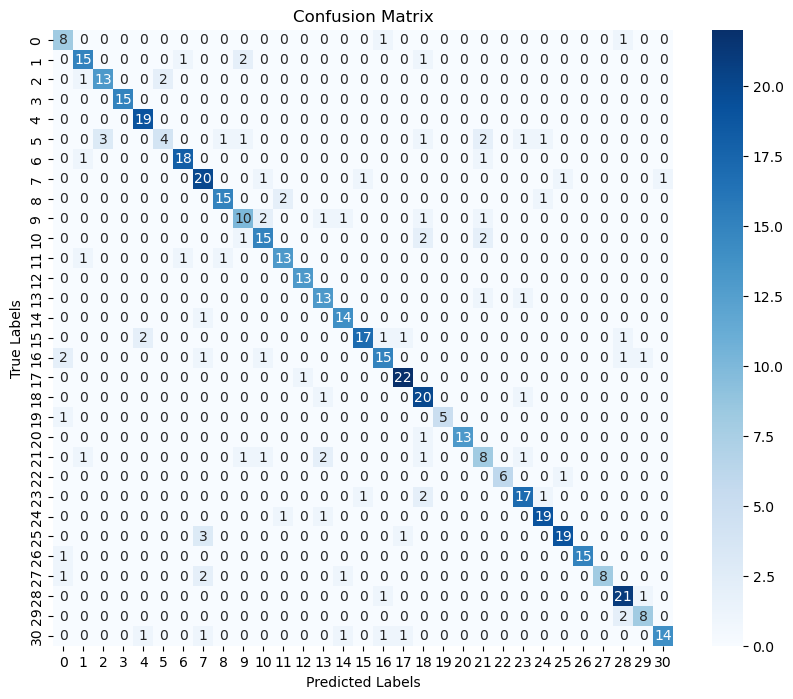

loaded successfully!
Extracting features for image: b.png
1/1 [==============================] - 0s 411ms/step
Predicting label...
The predicted name for the image 'b.png' is: Billie Eilish


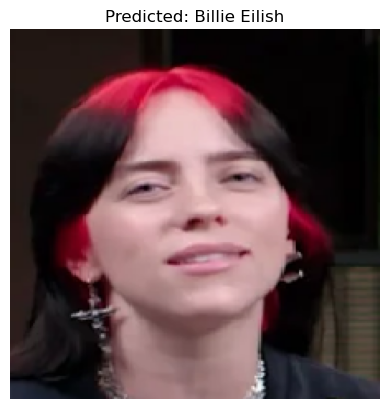

Extracting features for image: t.jpg
1/1 [==============================] - 0s 45ms/step
Predicting label...
The predicted name for the image 't.jpg' is: Tom Cruise


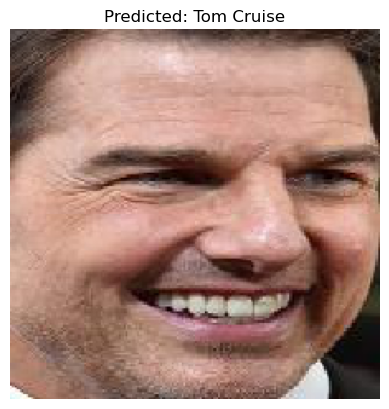

Extracting features for image: h.png
1/1 [==============================] - 0s 44ms/step
Predicting label...
The predicted name for the image 'h.png' is: Unknown


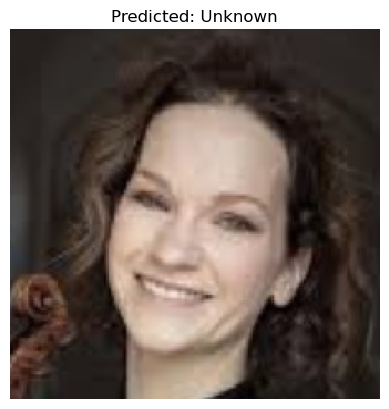

Extracting features for image: z.jpg
1/1 [==============================] - 0s 44ms/step
Predicting label...
The predicted name for the image 'z.jpg' is: Zac Efron


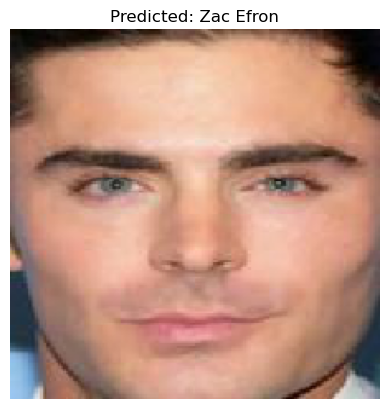

In [15]:
# Step 5: Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


resnet_model = load_model("resnet_model.h5")
svm_classifier = joblib.load("svm_classifier.pkl")
inverse_class_indices = joblib.load("class_mapping.pkl")
print("loaded successfully!")

# Define function to predict a single image
def predict_single_image(img_path, resnet_model, svm_model, class_mapping, threshold=0.5):
    """
    Predict the label for a single image and return the class name or 'Unknown' if confidence is low.
    :param img_path: Path to the image file.
    :param resnet_model: Pre-trained ResNet model.
    :param svm_model: Trained SVM classifier.
    :param class_mapping: Dictionary mapping numeric labels to class names.
    :param threshold: Confidence threshold for predicting 'Unknown'.
    :return: Predicted class name or 'Unknown'.
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(imagesize_target, imagesize_target))  # Resize to ResNet input size
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))  # Add batch dimension and preprocess
    
    # Extract features using ResNet
    print(f"Extracting features for image: {img_path}")
    image_features = resnet_model.predict(img_array)  # Extract features
    image_features_flat = image_features.mean(axis=(1, 2))  # Global Average Pooling

    # Predict label using SVM with probabilities
    print("Predicting label...")
    probabilities = svm_model.predict_proba(image_features_flat)  # Get probability estimates
    max_prob = probabilities.max()  # Get the highest probability
    if max_prob < threshold:  # Threshold to classify as 'Unknown'
        return "Unknown", img
    else:
        numeric_label = probabilities.argmax()  # Get class with the highest probability
        class_name = class_mapping[numeric_label]
        return class_name, img

#Predict and display an individual image
img_path = "b.png"  # Replace with the path to a test image

try:
    # Predict the label
    predicted_class_name, img = predict_single_image(img_path, resnet_model, svm_classifier, inverse_class_indices)
    print(f"The predicted name for the image '{img_path}' is: {predicted_class_name}")
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {predicted_class_name}")
    plt.show()
except Exception as e:
    print(f"Error during prediction: {e}")

img_path = "t.jpg"  # Replace with the path to a test image

try:
    # Predict the label
    predicted_class_name, img = predict_single_image(img_path, resnet_model, svm_classifier, inverse_class_indices)
    print(f"The predicted name for the image '{img_path}' is: {predicted_class_name}")
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {predicted_class_name}")
    plt.show()
except Exception as e:
    print(f"Error during prediction: {e}")


img_path = "h.png"  # Replace with the path to a test image

try:
    # Predict the label
    predicted_class_name, img = predict_single_image(img_path, resnet_model, svm_classifier, inverse_class_indices)
    print(f"The predicted name for the image '{img_path}' is: {predicted_class_name}")
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {predicted_class_name}")
    plt.show()
except Exception as e:
    print(f"Error during prediction: {e}")


img_path = "z.jpg"  # Replace with the path to a test image
try:
    # Predict the label
    predicted_class_name, img = predict_single_image(img_path, resnet_model, svm_classifier, inverse_class_indices)
    print(f"The predicted name for the image '{img_path}' is: {predicted_class_name}")
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {predicted_class_name}")
    plt.show()
except Exception as e:
    print(f"Error during prediction: {e}")